In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
from newspaper import Article

from sklearn.metrics  import f1_score,accuracy_score
 
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import json
import pandas as pd
import numpy as np

# get json objects from /jsons folder into a pandas dataframe

jsons = pd.DataFrame(columns=["topic", "source", "bias", "url", "title", "date", "authors", "content", "content_original", "source_url", "bias_text", "ID"])
for file in os.listdir('jsons'):
    if file.endswith('.json'):
        with open(os.path.join('jsons', file)) as json_file:
            # get json object as dictionary
            data = json.load(json_file)
            # get values from dictionary in an array
            values = list(data.values())
            # put the values in a new row in the dataframe
            jsons.loc[len(jsons)] = values


In [4]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# get articles from dataframe
articles = jsons['content'].values

# remove english stopwords function
def remove_stopwords(text, language):
    text = text.lower()
    stop_words = set(stopwords.words(language))
    word_tokens = text.split()
    return " ".join([word for word in word_tokens if word not in stop_words])
    
# remove all non-letters keep spaces between words
articles = [re.sub("[^a-zA-Z ]", "", article) for article in articles]
articles = [remove_stopwords(article, 'english') for article in articles]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pbido\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# set processed_content column to the processed articles
jsons['processed_content'] = articles

In [7]:
# save dataframe to csv
jsons.to_csv('processed_articles.csv')

In [2]:
jsons = pd.read_csv('processed_articles.csv')
articles = jsons['processed_content'].values

In [8]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text, language):
    text = text.lower()
    stop_words = set(stopwords.words(language))
    word_tokens = text.split()
    return " ".join([word for word in word_tokens if word not in stop_words])

# Final function to clean the text
def clean_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text, "english")
    return text
    
articles = [clean_text(article) for article in articles]


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

x = cv.fit_transform(articles)

## Neighbor Classifier

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from copy import copy

# parameters of classifier
k = 3

y_feat = 'bias_text'

y_true = jsons.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = KFold(n_splits=4)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

## Random Forest Classifier

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

n_splits = 5
max_depth = 7

y_feat = 'bias_text'
y = jsons.loc[:, y_feat].values

skfold = StratifiedKFold(n_splits=n_splits)

y_pred = np.empty_like(y)

rf_clf = RandomForestClassifier(n_estimators=10)

for train_idx, test_idx in skfold.split(x, y):
    x_train = x[train_idx, :]
    y_train = y[train_idx]

    x_test = x[test_idx, :]

    rf_clf = rf_clf.fit(x_train, y_train)

    y_pred[test_idx] = rf_clf.predict(x_test)


## SVM Classifier

In [15]:
from sklearn import svm

n_splits = 3

y_feat = 'bias_text'
y = jsons.loc[:, y_feat].values

skfold = StratifiedKFold(n_splits=n_splits)

y_pred = np.empty_like(y)

clf = svm.SVC()

for train_idx, test_idx in skfold.split(x, y):
    x_train = x[train_idx, :]
    y_train = y[train_idx]

    x_test = x[test_idx, :]

    clf = clf.fit(x_train, y_train)

    y_pred[test_idx] = clf.predict(x_test)


NameError: name 'y_true' is not defined

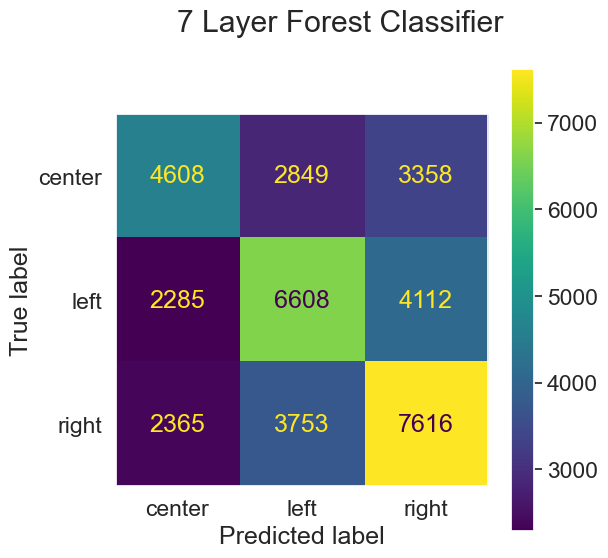

In [13]:
# build and plot confusion matrix
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))

sns.set(font_scale=1.5)
conf_mat_disp.plot()
plt.suptitle('7 Layer Forest Classifier')
plt.gcf().set_size_inches(6, 6)
plt.grid(False)

# change font size of predicted label
plt.gca().set_xticklabels(np.unique(y_true), fontsize=12)

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y, y_pred=y_pred)

0.5256963306172445